In [1]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential


def generador_de_imagenes():

    generador = Sequential()

    generador.add(Dense(256*4*4, input_shape = (100,)))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU())
    generador.add(Reshape((4,4,256)))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))


    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generador)

modelo_generador = generador_de_imagenes()

modelo_generador.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         295040    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


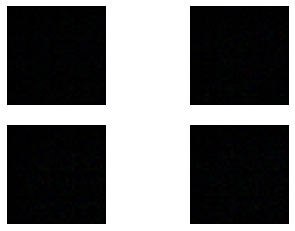

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Definir datos de entrada
def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

numero_muestras = 4
X,_ = crear_datos_fake(modelo_generador, numero_muestras)

# Visualizamos resultados
for i in range(numero_muestras):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])

In [3]:
from keras.layers import Conv2D, Flatten, Dropout
from keras.optimizers import Adam

def discriminador_de_imagenes():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

modelo_discriminador = discriminador_de_imagenes()
modelo_discriminador.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

In [10]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_NEAREST)
        if img is not None:
            images.append(img)
    return images    

In [11]:
%%time
images = load_images_from_folder(folder="../src/api/uploads")

Wall time: 152 ms


In [12]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(modelo_discriminador,modelo_generador)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         1007363   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 522497    
Total params: 1,529,860
Trainable params: 1,007,363
Non-trainable params: 522,497
_________________________________________________________________


In [13]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):

  # We save the model
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # We generate new data
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

  # We evaluate the model
  _, acc_real = modelo_discriminador.evaluate(X_real, Y_real)
  _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [14]:
def entrenamiento(datos, modelo_generador, modelo_discriminador, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # We iterate over the epochs
  for epoch in range(inicio, inicio + epochs):
    # We iterate over all batches
    for batch in range(n_batch):

      # We load all the real data
      X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)


      # We train the discriminator withEnrenamos discriminador con datos reales
      coste_discriminador_real, _ = modelo_discriminador.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

      coste_discriminador_fake, _ = modelo_discriminador.train_on_batch(X_fake, Y_fake)

      # We generate input images for the GAN
      X_gan = generar_datos_entrada(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # We train the GAN with fake data
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Every 10 epochs we show the results and cost 
    if (epoch+1) % 10 == 0:
      evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
      mostrar_imagenes_generadas(X_fake, epoch = epoch)

In [18]:
images = np.asarray(images)

In [21]:
entrenamiento(images, modelo_generador, modelo_discriminador, epochs = 300, n_batch=128, inicio = 0)


NameError: name 'dataset' is not defined

In [20]:
import random

def cargar_datos_reales(dataset, n_muestras):
  ix = np.random.randint(0, dataset.shape[0], n_muestras)
  X = dataset[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(32 * 32 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 32,32,3))
  y = np.zeros((n_muestras, 1))
  return X,y